In [151]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [1]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

In [511]:
FILE_NAME = "BT_data_with_lists.xlsx"
df = pd.read_excel(FILE_NAME)
df["cbalance_level"] = df["balance_level"].cumsum()

<function matplotlib.pyplot.show(close=None, block=None)>

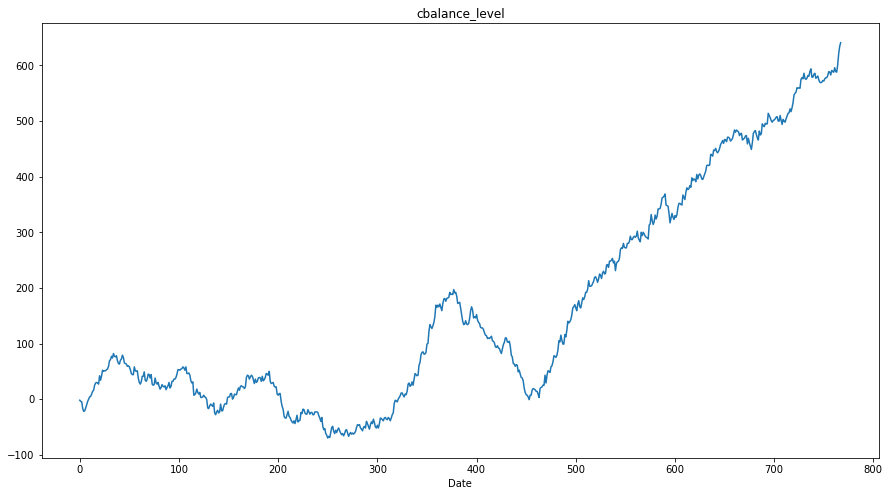

In [512]:
plt.figure(figsize=(15,8))
plt.title('cbalance_level')
plt.plot(df['cbalance_level'])
plt.xlabel('Date')
plt.show

In [513]:
data = df.filter(['cbalance_level'])
dataset = data.values
len(dataset)

768

In [514]:
training_data_size = math.ceil(len(dataset)*.70)
training_data_size

538

In [515]:
# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [516]:
# specific the shape of input, 60 observation of the sample
train_data = scaled_data[0:training_data_size, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
#     if i<=60:
#         print(x_train)
#         print(y_train)
        

In [517]:
x_train, y_train = np.array(x_train), np.array(y_train)
# LSTM: input 3d - number of shapes, number of steps, number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(478, 60, 1)

In [518]:
# using sequential to build LSTM model
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [519]:
history = regressor.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
15/15 [==============================] - 33s 144ms/step - loss: 0.0170
Epoch 2/50
15/15 [==============================] - 2s 136ms/step - loss: 0.0043
Epoch 3/50
15/15 [==============================] - 2s 131ms/step - loss: 0.0027
Epoch 4/50
15/15 [==============================] - 2s 127ms/step - loss: 0.0023
Epoch 5/50
15/15 [==============================] - 2s 130ms/step - loss: 0.0022
Epoch 6/50
15/15 [==============================] - 2s 143ms/step - loss: 0.0014
Epoch 7/50
15/15 [==============================] - 2s 147ms/step - loss: 0.0015
Epoch 8/50
15/15 [==============================] - 2s 136ms/step - loss: 0.0015
Epoch 9/50
15/15 [==============================] - 2s 138ms/step - loss: 0.0012
Epoch 10/50
15/15 [==============================] - 2s 135ms/step - loss: 0.0012
Epoch 11/50
15/15 [==============================] - 2s 154ms/step - loss: 0.0012
Epoch 12/50
15/15 [==============================] - 2s 136ms/step - loss: 0.0011
Epoch 13/50
15/15 [=====

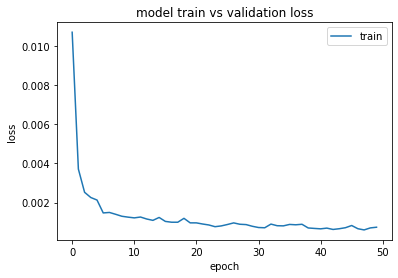

In [520]:
# plot train and validation loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [521]:
test_data = scaled_data[training_data_size - 60: ,:] # 60+30%*or_size
x_test = []
y_test = dataset[training_data_size, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [522]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [523]:
predictions = regressor.predict(x_test)

In [524]:
predictions = scaler.inverse_transform(predictions)

In [525]:
predictions[:5]

array([[246.01431],
       [249.58296],
       [252.30907],
       [253.45659],
       [253.04297]], dtype=float32)

In [ ]:
predictions[:5]

In [526]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse #why rmse is so high?

193.14371609895124

In [527]:
train = data[:training_data_size]
valid = data[training_data_size:]

In [528]:
valid['predictions'] = predictions

<ipython-input-528-add9aff4bf78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


In [531]:
valid.head(10) # looks bad in first 10 elements

,cbalance_level,predictions
538,245,246.014313
539,248,249.582962
540,231,252.309067
541,244,253.456589
542,247,253.042969
543,248,251.546051
544,253,249.580368
545,269,247.832672
546,272,247.296509
547,271,248.640045


<ipython-input-532-78b812477c69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


<function matplotlib.pyplot.show(close=None, block=None)>

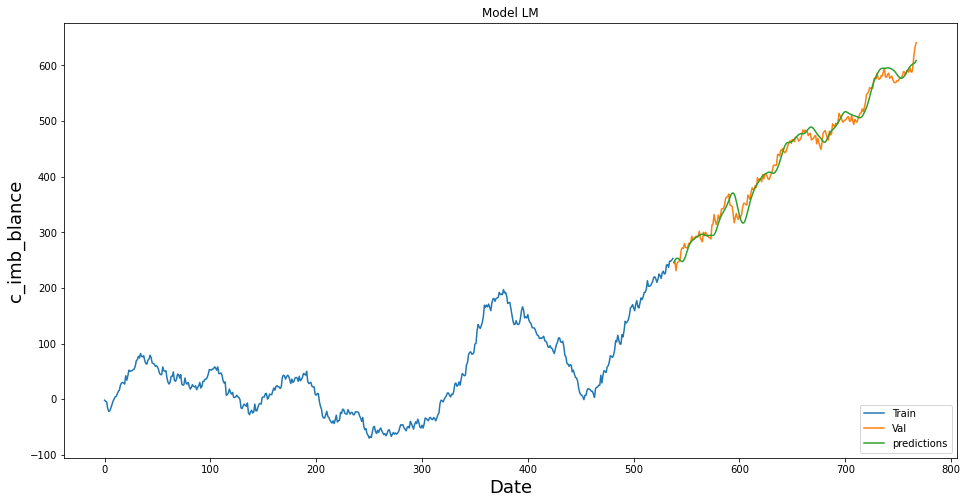

In [532]:
train = data[:training_data_size]
valid = data[training_data_size:]
valid['predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model LM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('c_imb_blance', fontsize=18)
plt.plot(train['cbalance_level'])
plt.plot(valid[['cbalance_level','predictions']])
plt.legend(['Train', 'Val', 'predictions'], loc='lower right')
plt.show

In [533]:
# 0-800 means first date to 800th date. we have 700+ days record in dataset

## decision tree regression and linear regression model

In [198]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [199]:
FILE_NAME = "BT_data_with_lists.xlsx"
df = pd.read_excel(FILE_NAME)
df["cbalance_level"] = df["balance_level"].cumsum()

<function matplotlib.pyplot.show(close=None, block=None)>

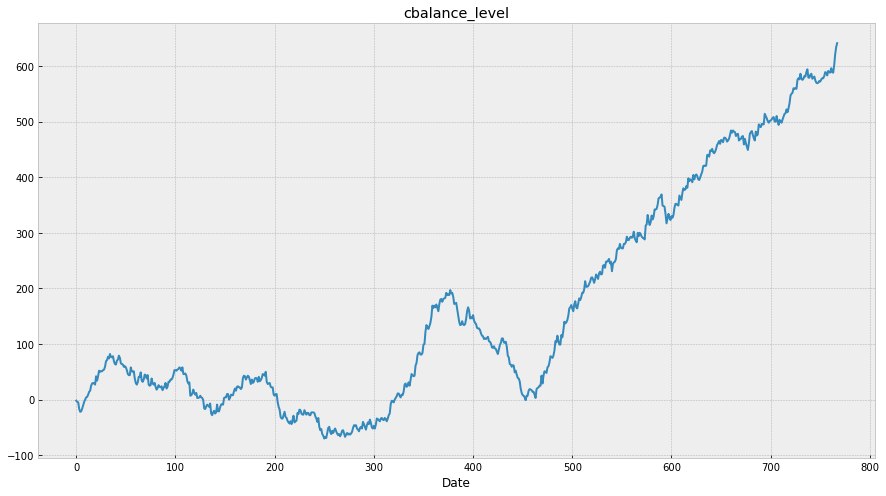

In [200]:
plt.figure(figsize=(15,8))
plt.title('cbalance_level')
plt.plot(df['cbalance_level'])
plt.xlabel('Date')
plt.show

In [201]:
df = df.filter(['cbalance_level'])
data.head(5)

,cbalance_level
0,-2
1,-4
2,-5
3,-17
4,-22


In [202]:
# 10 days in the end of the dataset
future_days = 10
# 
df['Prediction'] = df[['cbalance_level']].shift(-future_days)
df.tail(4)

,cbalance_level,Prediction
764,601,NaN
765,621,NaN
766,634,NaN
767,641,NaN


In [203]:
x = np.array(df.drop(['Prediction'],1))[:-future_days]

In [204]:
y = np.array(df['Prediction'])[:-future_days]

In [205]:
# 0.3 -> 70% training data and 30% testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [206]:
# decision tree regressor model
tree = DecisionTreeRegressor().fit(x_train, y_train)
# linear regression model
lr = LinearRegression().fit(x_train, y_train)

In [207]:
x_future = df.drop(['Prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)

In [208]:
tree_prediction = tree.predict(x_future)
lr_prediction = lr.predict(x_future)

In [209]:
#Visualize the data
predictions = tree_prediction

valid = df[x.shape[0]:]
valid['Prediction'] = predictions

<ipython-input-209-9bb975c87e6f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predictions


In [210]:
valid.head(10)

,cbalance_level,Prediction
758,591,589.500000
759,589,589.000000
760,588,589.000000
761,596,596.000000
762,589,585.333333
763,588,585.333333
764,601,591.000000
765,621,621.000000
766,634,634.000000
767,641,641.000000


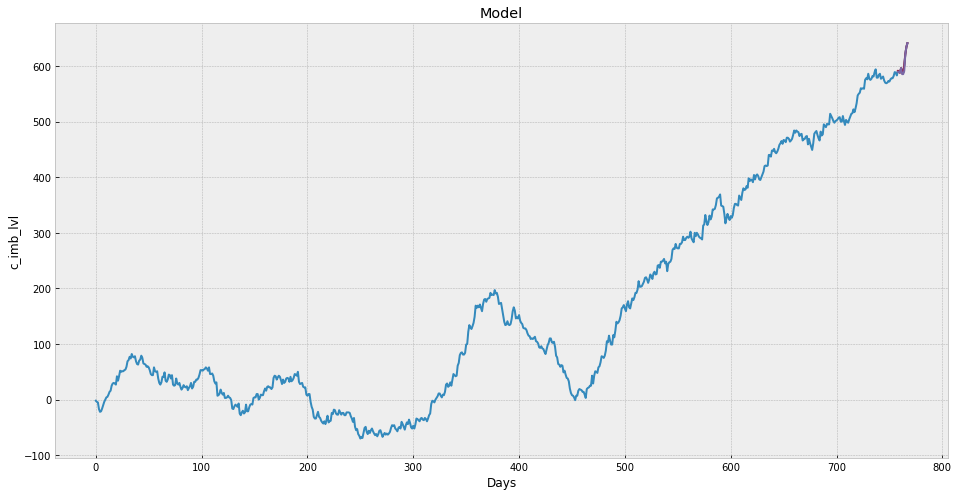

In [211]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('c_imb_lvl')
plt.plot(df['cbalance_level'])
plt.plot(valid[['cbalance_level', 'Prediction']])
plt.show()

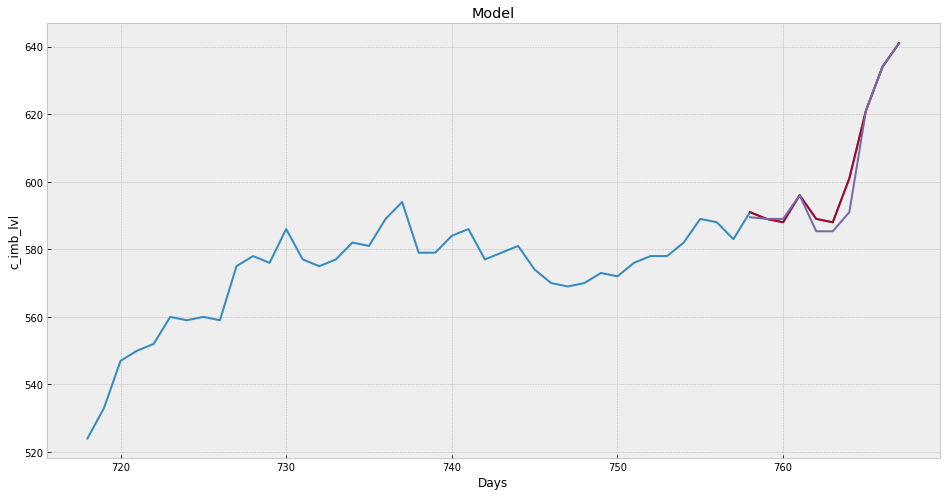

In [212]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('c_imb_lvl')
plt.plot(df['cbalance_level'].tail(50))
plt.plot(valid[['cbalance_level', 'Prediction']])
plt.show()